In [40]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split
from music21 import *
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from tensorflow.keras.optimizers import Adam

## Wavenet Modeling Iterations

### Process Midis using music21

In [24]:
#https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #if note or a chord
            for element in notes_to_parse:
                
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [29]:
path='/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])
#read in these particular files from archive(1) in google colab

Loading Music File: /chpn-p15.mid
Loading Music File: /chpn_op10_e05.mid
Loading Music File: /beethoven_opus10_1.mid
Loading Music File: /chpn_op27_1.mid
Loading Music File: /chpn_op35_1.mid
Loading Music File: /chpn-p23.mid
Loading Music File: /bor_ps7.mid
Loading Music File: /beethoven_hammerklavier_1.mid
Loading Music File: /chpn-p19.mid
Loading Music File: /chpn-p4.mid
Loading Music File: /chpn-p5.mid
Loading Music File: /mond_2.mid
Loading Music File: /chpn_op35_3.mid
Loading Music File: /chpn_op10_e01.mid
Loading Music File: /chp_op18.mid
Loading Music File: /alb_se7.mid
Loading Music File: /alb_se6.mid
Loading Music File: /alb_esp3.mid
Loading Music File: /elise.mid
Loading Music File: /bor_ps3.mid
Loading Music File: /alb_se1.mid
Loading Music File: /beethoven_les_adieux_1.mid
Loading Music File: /alb_se2.mid
Loading Music File: /beethoven_opus90_2.mid
Loading Music File: /waldstein_2.mid
Loading Music File: /bor_ps6.mid
Loading Music File: /mond_1.mid
Loading Music File: /chp_

Increased the quantity of midi files for this iteration to over 120 files.

In [ ]:
#flatten array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

In [31]:
print(len(notes_))

178053


In [32]:
print("First fifty notes:",notes_[:50])

First fifty notes: ['F5', 'C#3', 'G#3', 'C#5', 'G#4', '1.5', 'G#3', 'G#3', 'G#3', 'B-4', '1.5', 'G#3', 'C5', '3.6', 'G#3', 'G#3', 'G#3', 'B-3', 'G#3', 'C#5', '1.5', 'G#3', '3.6', 'C4', 'G#3', '5.8', '6.10', 'G#3', 'G#3', 'G#3', '8.1', 'F5', 'G#3', 'G#4', 'F5', 'C4', 'G#3', 'F#4', 'E-5', 'G#3', 'C#5', '1.5', 'G#3', 'E-5', 'E-5', '0.6', 'F5', 'E-5', 'D5', 'E-5']


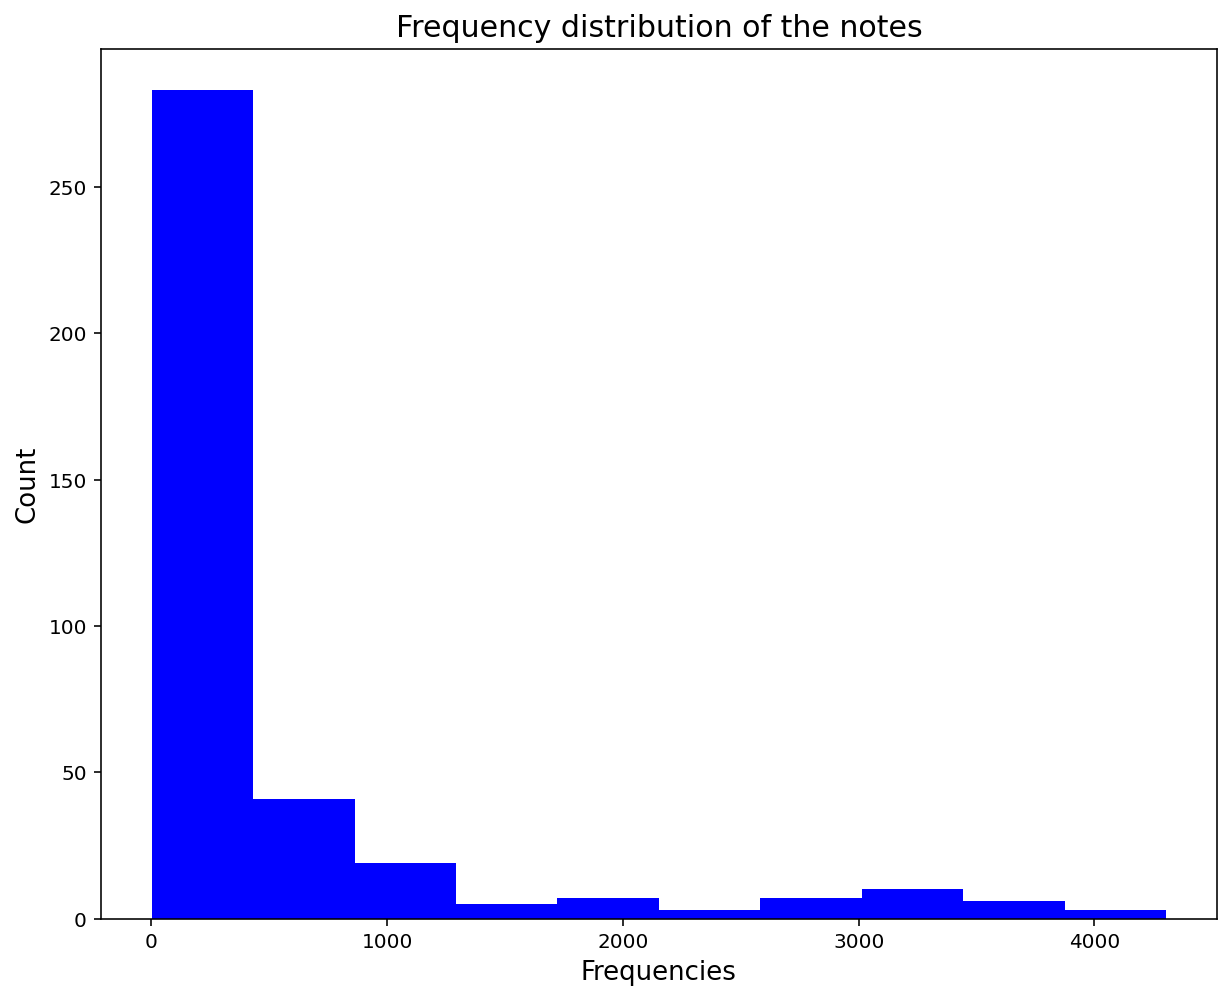

In [79]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
only_freq=[count for _,count in freq.items()]

plt.figure(figsize=(10,8))

plt.title("Frequency distribution of the notes", fontsize=15)
plt.ylabel('Count', fontsize= 13)
plt.xlabel('Frequencies', fontsize= 13)
plt.hist(only_freq, color = 'blue')
plt.savefig('2nddistplot.png');

When increasing the number of songs, we still encounter the same fact that low frequencies are the most widely used in music. 

In [34]:
frequent_notes = [note_ for note_, count in freq.items() if count>=40]
#for this modeling frequent notes has been redefined to >40.  
#We had it initially defined as >50 in the first version of the model
print(len(frequent_notes))

210


In [35]:
#files will only contain frequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [36]:
#preparing input and output sequences where input is sequence of amplitude values and the output is the subsequent value
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [37]:
#Each note gets a unique integer
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [38]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [39]:
#preparing integer sequences for output data.
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [44]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [41]:
model = Sequential()

model.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
#conv1d learns local patterns of dta in cnns
model.add(Conv1D(32,3, padding= 'causal', activation = 'relu'))
#added layer from original model
model.add(Dropout(0.4))
model.add(MaxPool1D(2))
model.add(Conv1D(64,3, padding = 'causal', activation = 'relu'))
#increase dropouts
model.add(Dropout(0.4))
# reduce dimensionality of this vector and overfitting, 
# we dont want to just repeat notes
model.add(MaxPool1D(2))
model.add(Conv1D(128,3, activation= 'relu', dilation_rate=2, padding='causal'))
#increase dropout again
model.add(Dropout(0.4))
model.add(MaxPool1D(2))
model.add(Conv1D(256,3, activation = 'relu', dilation_rate=4, padding= 'causal'))
model.add(Dropout(0.4))
model.add(MaxPool1D(2))

model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(lr=0.0005))
#decreased adam learning rate to .00005 from default in original model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           21000     
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            9632      
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            6208      
                                                                 
 dropout_1 (Dropout)         (None, 16, 64)            0         
                                                        

In [42]:
mc=ModelCheckpoint('best_model_2.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

In [45]:
history = model.fit(np.array(x_tr), np.array(y_tr), batch_size=64, 
                    epochs=65, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc])
#increased epochs and decreased batch size from original model

Epoch 1/65
2164/2164 [==============================] - ETA: 0s - loss: 4.3411
Epoch 00001: val_loss improved from inf to 4.58382, saving model to best_model_2.h5
2164/2164 [==============================] - 24s 6ms/step - loss: 4.3411 - val_loss: 4.5838
Epoch 2/65
2157/2164 [============================>.] - ETA: 0s - loss: 4.0372
Epoch 00002: val_loss improved from 4.58382 to 4.41425, saving model to best_model_2.h5
2164/2164 [==============================] - 14s 7ms/step - loss: 4.0372 - val_loss: 4.4142
Epoch 3/65
2164/2164 [==============================] - ETA: 0s - loss: 3.9468
Epoch 00003: val_loss improved from 4.41425 to 4.25359, saving model to best_model_2.h5
2164/2164 [==============================] - 14s 6ms/step - loss: 3.9468 - val_loss: 4.2536
Epoch 4/65
2161/2164 [============================>.] - ETA: 0s - loss: 3.8863
Epoch 00004: val_loss improved from 4.25359 to 4.22513, saving model to best_model_2.h5
2164/2164 [==============================] - 14s 6ms/step - 

In [46]:
from keras.models import load_model
model =load_model('best_model_2.h5')

In [71]:
import random
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions = []

for i in range(15):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions)

[82, 170, 39, 39, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]


In [72]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))

predicted_notes = [x_int_to_note[i] for i in predictions]

In [74]:
# convert preds to midi files
def convert_to_midi(prediction_output):

  offset = 0
  output_notes = []

  for pattern in prediction_output:

    if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
    else:    
      new_note = note.Note(pattern)
      new_note.offset = offset
      new_note.storedInstrument = instrument.Piano()
      output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
    offset += 1
  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp='music2.mid')

In [96]:
convert_to_midi(predicted_notes)

In [76]:
predicted_notes

['B-4',
 'G#4',
 'C#5',
 'C#5',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-4']

Model worsened, also predictions are underwhelming with the same note appearing 12/15 times.

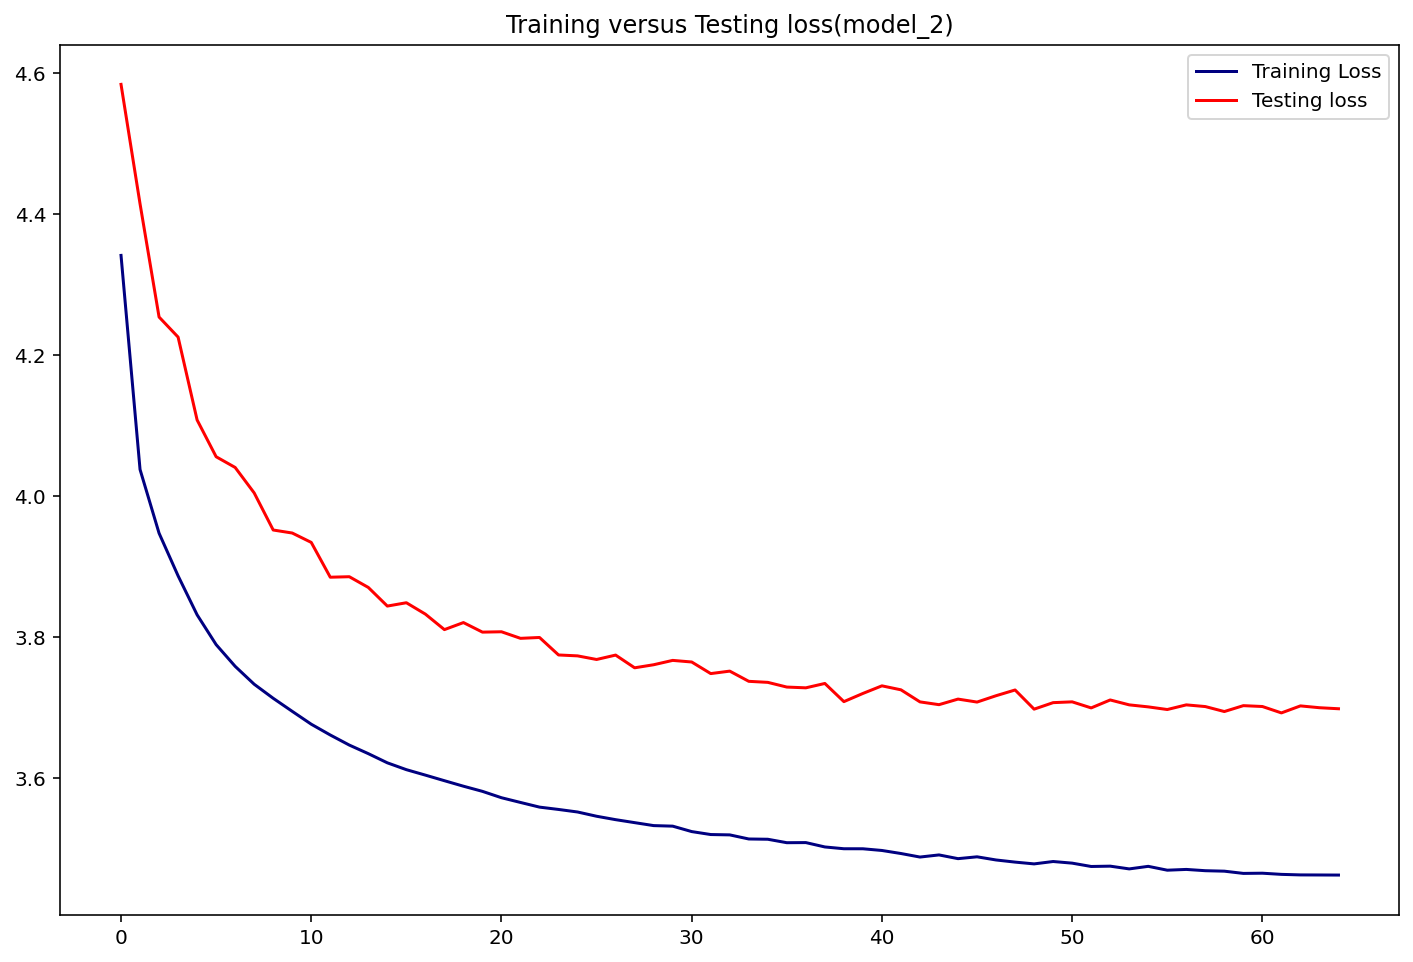

In [78]:
train_loss=history.history['loss']
test_loss= history.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_2)')
plt.plot(train_loss, label ='Training Loss', color = 'navy')
plt.plot(test_loss, label = 'Testing loss', color = 'red')
plt.legend();
plt.savefig('2ndmodel_loss_plot.png')

This model actually performed worse than the initial one.  It is even more overfit and has increased its val_loss from 3.04(original model) to 3.69174.

In [80]:
model3 = Sequential()

model3.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
#conv1d learns local patterns of dta in cnns
model3.add(Conv1D(32,3, padding= 'causal', activation = 'relu'))
#added layer from original model
model3.add(Dropout(0.3))
model3.add(MaxPool1D(2))
model3.add(Conv1D(64,3, padding = 'causal', activation = 'relu'))
#decrease dropouts from second model
model3.add(Dropout(0.3))
# reduce dimensionality of this vector and overfitting, 
# we dont want to just repeat notes
model3.add(MaxPool1D(2))
model3.add(Conv1D(128,3, activation= 'relu', dilation_rate=2, padding='causal'))
#increase dropout again
model3.add(Dropout(0.3))
model3.add(MaxPool1D(2))
model3.add(Conv1D(256,3, activation = 'relu', dilation_rate=4, padding= 'causal'))
model3.add(Dropout(0.3))
model3.add(MaxPool1D(2))

model3.add(GlobalMaxPool1D())

model3.add(Dense(256, activation='relu'))
model3.add(Dense(len(unique_y), activation = 'softmax'))

model3.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(lr=0.0009))
#changed adam learning rate to .00009 increase from 2nd model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           21000     
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            9632      
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            6208      
                                                                 
 dropout_1 (Dropout)         (None, 16, 64)            0         
                                                        

In [82]:
mc3=ModelCheckpoint('best_model_3.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

In [83]:
history3 = model3.fit(np.array(x_tr), np.array(y_tr), batch_size=64, 
                    epochs=65, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc3])

Epoch 1/65
2164/2164 [==============================] - ETA: 0s - loss: 4.2530
Epoch 00001: val_loss improved from inf to 4.23672, saving model to best_model_3.h5
2164/2164 [==============================] - 15s 6ms/step - loss: 4.2530 - val_loss: 4.2367
Epoch 2/65
2163/2164 [============================>.] - ETA: 0s - loss: 3.9570
Epoch 00002: val_loss improved from 4.23672 to 4.13722, saving model to best_model_3.h5
2164/2164 [==============================] - 14s 6ms/step - loss: 3.9570 - val_loss: 4.1372
Epoch 3/65
2164/2164 [==============================] - ETA: 0s - loss: 3.8762
Epoch 00003: val_loss improved from 4.13722 to 4.04014, saving model to best_model_3.h5
2164/2164 [==============================] - 14s 6ms/step - loss: 3.8762 - val_loss: 4.0401
Epoch 4/65
2163/2164 [============================>.] - ETA: 0s - loss: 3.8180
Epoch 00004: val_loss improved from 4.04014 to 3.97372, saving model to best_model_3.h5
2164/2164 [==============================] - 14s 6ms/step - 

Model loss improved from 3.69174 to 3.60457.  Very small improvement.

In [84]:
model3 =load_model('best_model_3.h5')

In [91]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions3 = []

for i in range(20):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model3.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions3.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions3)

[17, 103, 103, 103, 103, 17, 103, 17, 17, 103, 84, 17, 17, 17, 76, 17, 76, 76, 76, 76]


In [92]:
predicted_notes3 = [x_int_to_note[i] for i in predictions3]

In [93]:
convert_to_midi(predicted_notes3)

In [94]:
predicted_notes3

['8.11',
 '6.9',
 '6.9',
 '6.9',
 '6.9',
 '8.11',
 '6.9',
 '8.11',
 '8.11',
 '6.9',
 'F#3',
 '8.11',
 '8.11',
 '8.11',
 '3.6',
 '8.11',
 '3.6',
 '3.6',
 '3.6',
 '3.6']

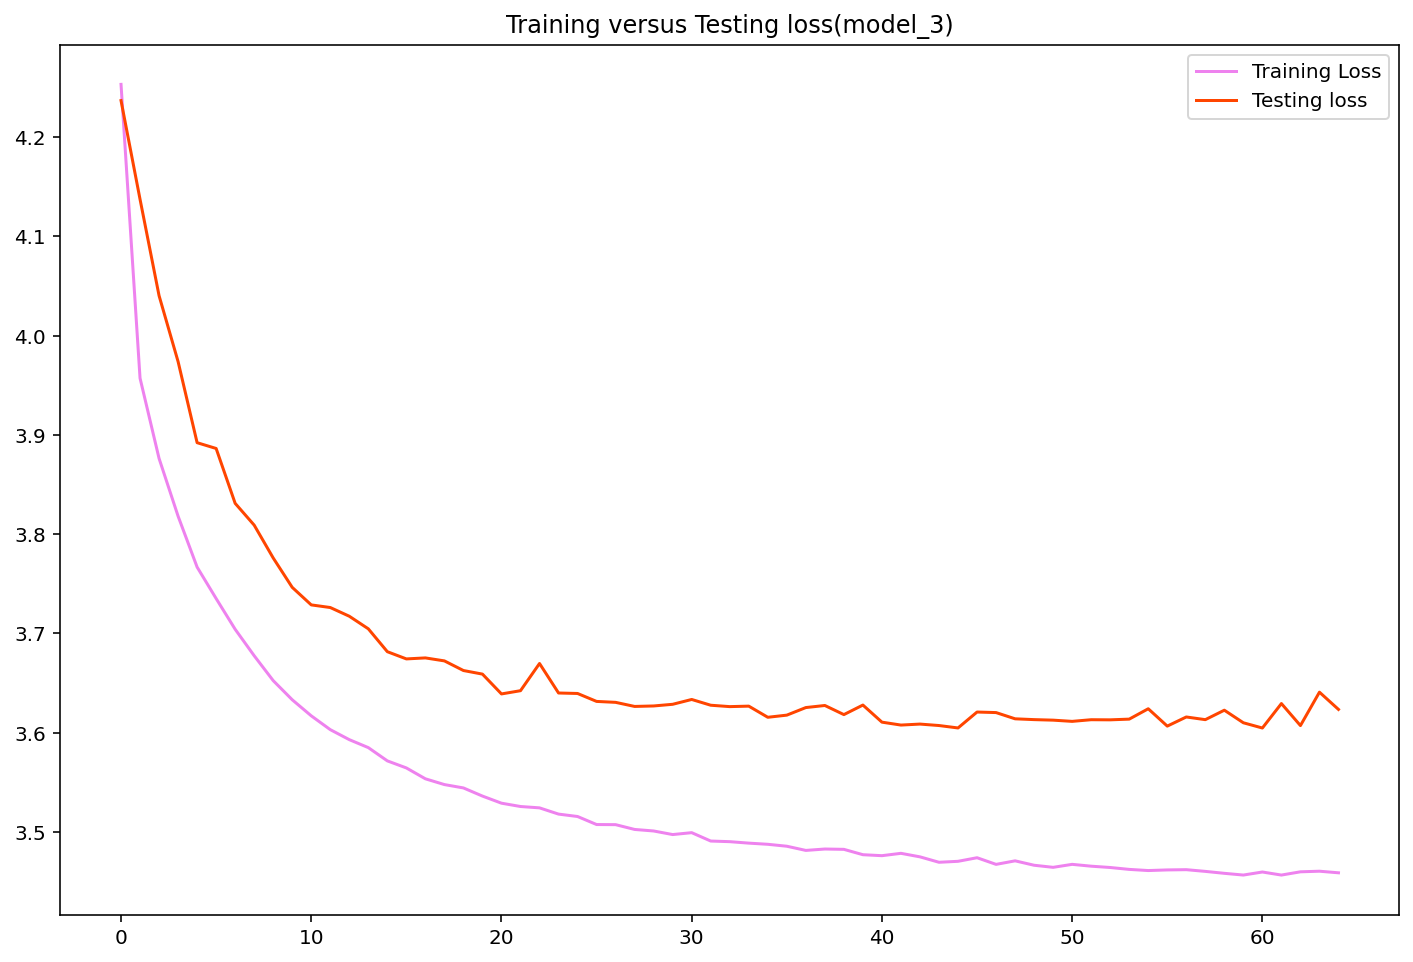

In [110]:
train_loss3=history3.history['loss']
test_loss3= history3.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_3)')
plt.plot(train_loss3, label ='Training Loss', color = 'violet')
plt.plot(test_loss3, label = 'Testing loss', color = 'orangered')
plt.legend();
plt.savefig('3rdmodel_loss_plot.png')

This iteration adjusts the learning rate for adam to .0009.  The dropout is also lowered to 0.3, since overfitting does not seem to be an issue.  The value of the loss function is 3.60457.

In [98]:

model4 = Sequential()

model4.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
#conv1d learns local patterns of dta in cnns
#increased filter size to 512, subsequent layer decrease by half
model4.add(Conv1D(512,3, padding= 'causal', activation = 'relu'))
#added layer from original model
model4.add(Dropout(0.2))
model4.add(MaxPool1D(2))
model4.add(Conv1D(256,3, padding = 'causal', activation = 'relu'))
#decrease dropouts from second model
model4.add(Dropout(0.2))
# reduce dimensionality of this vector and overfitting, 
# we dont want to just repeat notes
model4.add(MaxPool1D(2))
model4.add(Conv1D(128,3, activation= 'relu', dilation_rate=2, padding='causal'))
#increase dropout again
model4.add(Dropout(0.2))
model4.add(MaxPool1D(2))
model4.add(Conv1D(64,3, activation = 'relu', dilation_rate=4, padding= 'causal'))
model4.add(Dropout(0.2))
model4.add(MaxPool1D(2))

model4.add(GlobalMaxPool1D())

model4.add(Dense(256, activation='relu'))
model4.add(Dense(len(unique_y), activation = 'softmax'))

model4.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(lr=0.0009))
#changed adam learning rate to .00009 increase from 2nd model
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 100)           21000     
                                                                 
 conv1d_12 (Conv1D)          (None, 32, 512)           154112    
                                                                 
 dropout_12 (Dropout)        (None, 32, 512)           0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 16, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 16, 256)           393472    
                                                                 
 dropout_13 (Dropout)        (None, 16, 256)           0         
                                                      

In [99]:
mc4=ModelCheckpoint('best_model_4.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

In [100]:
history4 = model4.fit(np.array(x_tr), np.array(y_tr), batch_size=64, 
                    epochs=60, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc4])

Epoch 1/60
2164/2164 [==============================] - ETA: 0s - loss: 4.2282
Epoch 00001: val_loss improved from inf to 4.07956, saving model to best_model_4.h5
2164/2164 [==============================] - 14s 6ms/step - loss: 4.2282 - val_loss: 4.0796
Epoch 2/60
2157/2164 [============================>.] - ETA: 0s - loss: 3.8985
Epoch 00002: val_loss improved from 4.07956 to 3.88409, saving model to best_model_4.h5
2164/2164 [==============================] - 13s 6ms/step - loss: 3.8984 - val_loss: 3.8841
Epoch 3/60
2159/2164 [============================>.] - ETA: 0s - loss: 3.7691
Epoch 00003: val_loss improved from 3.88409 to 3.80493, saving model to best_model_4.h5
2164/2164 [==============================] - 13s 6ms/step - loss: 3.7690 - val_loss: 3.8049
Epoch 4/60
2156/2164 [============================>.] - ETA: 0s - loss: 3.6799
Epoch 00004: val_loss improved from 3.80493 to 3.70712, saving model to best_model_4.h5
2164/2164 [==============================] - 13s 6ms/step - 

Bigger val loss decrease to 3.20868 from previous model val loss 3.60457.

In [101]:
model4 =load_model('best_model_4.h5')

In [106]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions4 = []

for i in range(30):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model4.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions4.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions4)

[137, 82, 16, 39, 81, 89, 16, 82, 81, 39, 16, 48, 137, 39, 16, 39, 81, 89, 16, 82, 0, 39, 16, 48, 137, 39, 16, 39, 0, 170]


In [107]:
predicted_notes4 = [x_int_to_note[i] for i in predictions4]

In [108]:
convert_to_midi(predicted_notes4)

In [109]:
predicted_notes4

['G#2',
 'B-4',
 'E-3',
 'C#5',
 'G3',
 'E-4',
 'E-3',
 'B-4',
 'G3',
 'C#5',
 'E-3',
 'E-5',
 'G#2',
 'C#5',
 'E-3',
 'C#5',
 'G3',
 'E-4',
 'E-3',
 'B-4',
 'G#3',
 'C#5',
 'E-3',
 'E-5',
 'G#2',
 'C#5',
 'E-3',
 'C#5',
 'G#3',
 'G#4']

Not that it necessarily indicates better music generation, but there is a bigger variety of notes in this model.

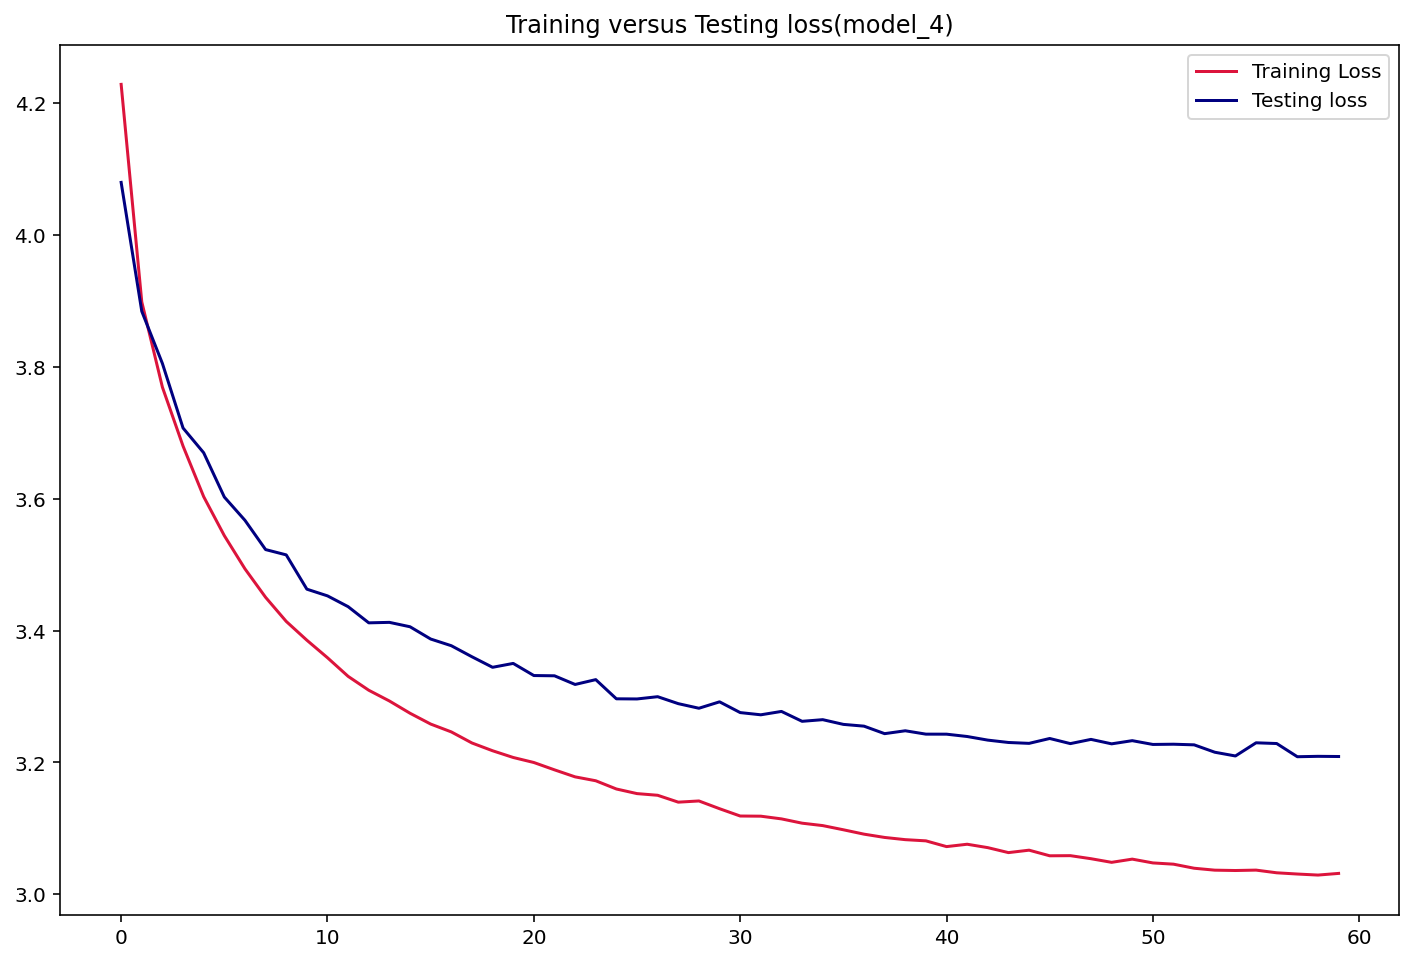

In [111]:
train_loss4=history4.history['loss']
test_loss4= history4.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_4)')
plt.plot(train_loss4, label ='Training Loss', color = 'crimson')
plt.plot(test_loss4, label = 'Testing loss', color = 'navy')
plt.legend();
plt.savefig('4thmodel_loss_plot.png')

Model 4 included a reduction of dropout to .2, and a change in how the layers are stacked by having the filter value start high and then descend. An increase in parameters seems to lead to a better value of the loss function:3.20868.

In [112]:
model5 = Sequential()
#adjusted first two dropout layers to .1 and .15
model5.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
#conv1d learns local patterns of dta in cnns
model5.add(Conv1D(512,3, padding= 'causal', activation = 'relu'))
#added layer from original model
model5.add(Dropout(0.1))
model5.add(MaxPool1D(2))
model5.add(Conv1D(256,3, padding = 'causal', activation = 'relu'))
#decrease dropouts from second model
model5.add(Dropout(0.15))
# reduce dimensionality of this vector and overfitting, 
# we dont want to just repeat notes
model5.add(MaxPool1D(2))
model5.add(Conv1D(128,3, activation= 'relu', dilation_rate=2, padding='causal'))
#increase dropout again
model5.add(Dropout(0.18))
model5.add(MaxPool1D(2))
model5.add(Conv1D(64,3, activation = 'relu', dilation_rate=4, padding= 'causal'))
model5.add(Dropout(0.2))
model5.add(MaxPool1D(2))

model5.add(GlobalMaxPool1D())

model5.add(Dense(256, activation='relu'))
model5.add(Dense(len(unique_y), activation = 'softmax'))

model5.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(lr=0.0007))
#changed adam learning rate to .00007 
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 100)           21000     
                                                                 
 conv1d_16 (Conv1D)          (None, 32, 512)           154112    
                                                                 
 dropout_16 (Dropout)        (None, 32, 512)           0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 16, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 16, 256)           393472    
                                                                 
 dropout_17 (Dropout)        (None, 16, 256)           0         
                                                      

In [113]:
mc5=ModelCheckpoint('best_model_5.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)

In [114]:
history5 = model5.fit(np.array(x_tr), np.array(y_tr), batch_size=32, #decreased batch size from 64
                    epochs=60, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc5])

Epoch 1/60
4324/4327 [============================>.] - ETA: 0s - loss: 4.2410
Epoch 00001: val_loss improved from inf to 4.03504, saving model to best_model_5.h5
4327/4327 [==============================] - 26s 6ms/step - loss: 4.2409 - val_loss: 4.0350
Epoch 2/60
4318/4327 [============================>.] - ETA: 0s - loss: 3.8943
Epoch 00002: val_loss improved from 4.03504 to 3.86306, saving model to best_model_5.h5
4327/4327 [==============================] - 25s 6ms/step - loss: 3.8939 - val_loss: 3.8631
Epoch 3/60
4318/4327 [============================>.] - ETA: 0s - loss: 3.7368
Epoch 00003: val_loss improved from 3.86306 to 3.74818, saving model to best_model_5.h5
4327/4327 [==============================] - 24s 6ms/step - loss: 3.7366 - val_loss: 3.7482
Epoch 4/60
4323/4327 [============================>.] - ETA: 0s - loss: 3.6235
Epoch 00004: val_loss improved from 3.74818 to 3.68422, saving model to best_model_5.h5
4327/4327 [==============================] - 25s 6ms/step - 

Model 5 has a val_loss of 3.21406 which is a slight increase from model 4s val_loss of 3.20868.

In [115]:
model5 =load_model('best_model_5.h5')

In [126]:
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions5 = []

for i in range(45):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model5.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions5.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions5)

[1, 20, 209, 209, 1, 82, 209, 6, 209, 82, 82, 82, 209, 82, 209, 209, 209, 49, 209, 59, 209, 49, 59, 59, 59, 59, 209, 49, 209, 209, 209, 209, 82, 209, 209, 49, 209, 209, 49, 49, 49, 209, 49, 82, 61]


In [127]:
predicted_notes5 = [x_int_to_note[i] for i in predictions5]

In [130]:
convert_to_midi(predicted_notes5)

In [128]:
predicted_notes5

['10.2',
 'B-5',
 'D5',
 'D5',
 '10.2',
 'B-4',
 'D5',
 '10.2.5',
 'D5',
 'B-4',
 'B-4',
 'B-4',
 'D5',
 'B-4',
 'D5',
 'D5',
 'D5',
 'F5',
 'D5',
 'G5',
 'D5',
 'F5',
 'G5',
 'G5',
 'G5',
 'G5',
 'D5',
 'F5',
 'D5',
 'D5',
 'D5',
 'D5',
 'B-4',
 'D5',
 'D5',
 'F5',
 'D5',
 'D5',
 'F5',
 'F5',
 'F5',
 'D5',
 'F5',
 'B-4',
 'C5']

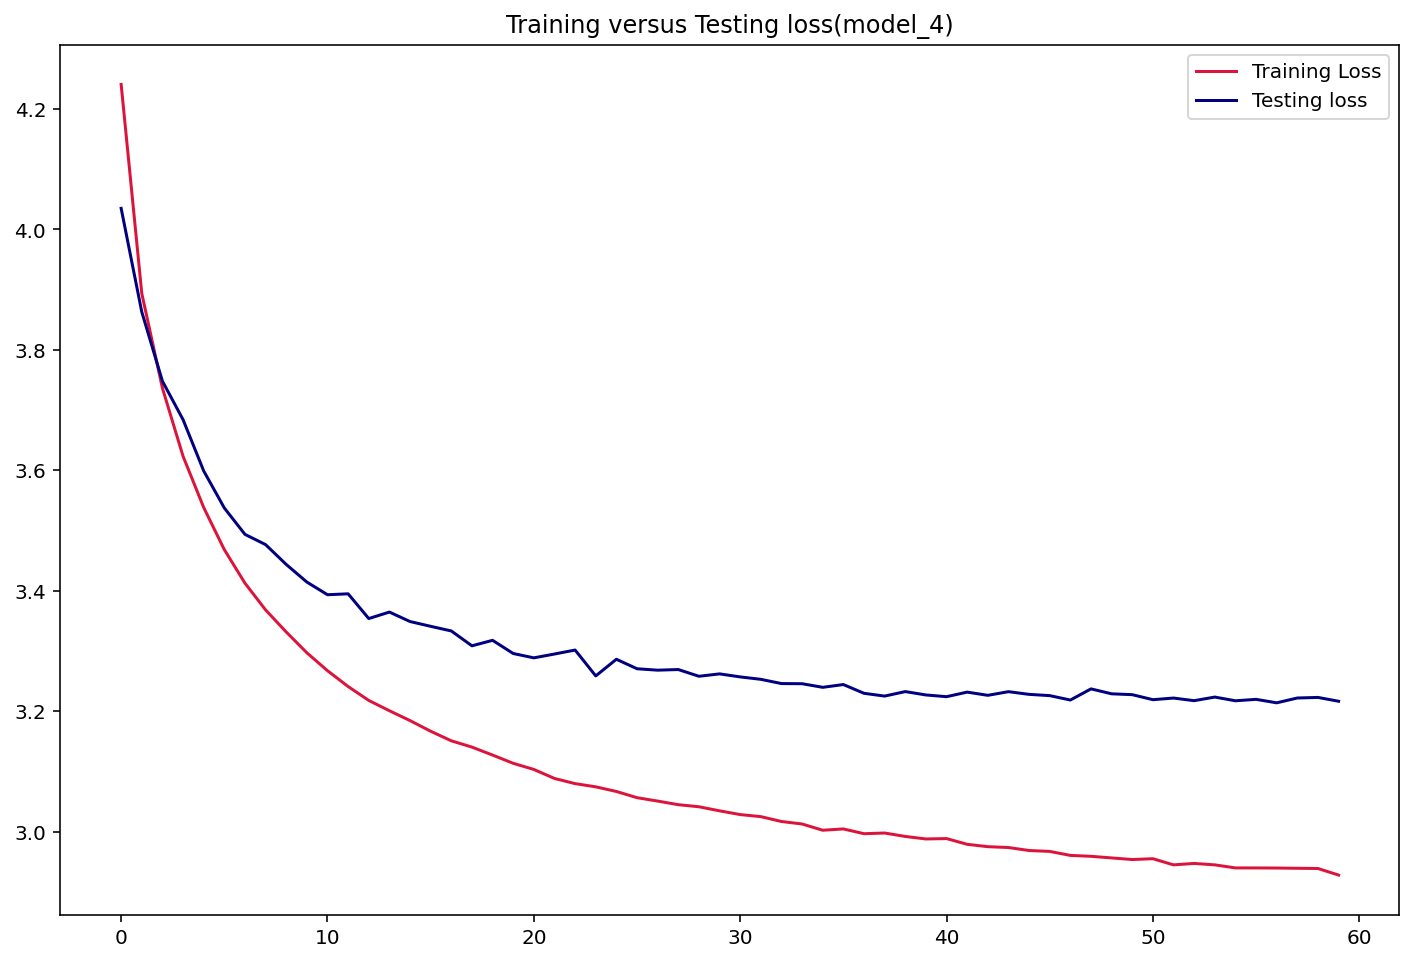

In [129]:
train_loss5=history5.history['loss']
test_loss5= history5.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss(model_4)')
plt.plot(train_loss5, label ='Training Loss', color = 'crimson')
plt.plot(test_loss5, label = 'Testing loss', color = 'navy')
plt.legend();
plt.savefig('5thmodel_loss_plot.png')

This version decreases dropouts to varying degrees for the first 2 layers.  Learning rate is decreased to .0007, the results are not too different from the previous model at 3.21.